In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [33]:
IDENTITY = lambda x: x
TO_TYPE = lambda t: lambda x: t(x)

def load_asset_data_to_df(
    ticker_name: str,
    fields_loader_lookup={
        "timestamp": TO_TYPE(np.datetime64),
        "close": IDENTITY,
    },
    argumentation_loader_lookup=[
        ("previous_day_close", lambda x: x["close"].shift(periods=1, fill_value=0)),
        ("gain_loss_percentage", lambda x: (x["close"] - x["previous_day_close"]) / x["previous_day_close"]),
        ("std", lambda x: x["gain_loss_percentage"].rolling(20).std()),
        ("inv_std", lambda x: 1 / x["std"])
    ]):
    ticker = pd.read_csv("{}.csv".format(ticker_name))
    # reverse the timeing order
    ticker = ticker.sort_values("timestamp")
    ticker.reset_index(inplace=True, drop=True)
    
    for (k, v) in fields_loader_lookup.items():
        ticker[k] = ticker[k].apply(v)
    for (k, v) in argumentation_loader_lookup:
        ticker[k] = v(ticker)

    return ticker

In [34]:
def trim_timeframe(dfs):
    lower_bound = np.max([df["timestamp"].min() for df in dfs])
    upper_bound = np.min([df["timestamp"].max() for df in dfs])
    
    for df in dfs:
        df.drop(df[df["timestamp"] < lower_bound].index, inplace=True)
        df.drop(df[df["timestamp"] > upper_bound].index, inplace=True)

In [35]:
def trim_nans(df):
    for c in df.columns.values:
        df.drop(df[df[c].isnull()].index, inplace=True)

In [36]:
assets_to_hold = ["VTSMX", "VUSTX"]

In [37]:
tickers = {x: load_asset_data_to_df(x) for x in assets_to_hold}
trim_timeframe(tickers.values())
for t in tickers.values():
    trim_nans(t)

In [38]:
def find_eq_volatility_allocation(tickers):
    df = pd.DataFrame()
    df["timestamp"] = list(tickers.values())[0]["timestamp"]
    df["total_volatility"] = list(tickers.values())[0]["inv_std"] * 0
    
    for t in tickers.values():
        df["total_volatility"] = df["total_volatility"] + t["inv_std"]
    
    for k, v in tickers.items():
        df["{}_weight".format(k.lower())] = v["inv_std"] / df["total_volatility"]
    return df

In [39]:
allocation = find_eq_volatility_allocation(tickers)

allocation

,timestamp,total_volatility,vtsmx_weight,vustx_weight
20,2000-02-08,247.116340,0.320361,0.679639
21,2000-02-09,249.244074,0.312523,0.687477
22,2000-02-10,239.954012,0.325903,0.674097
23,2000-02-11,245.944482,0.313435,0.686565
24,2000-02-14,247.383654,0.319236,0.680764
...,...,...,...,...
5049,2020-02-05,247.711963,0.485549,0.514451
5050,2020-02-06,251.672192,0.479540,0.520460
5051,2020-02-07,246.708473,0.485784,0.514216
5052,2020-02-10,247.552526,0.479779,0.520221


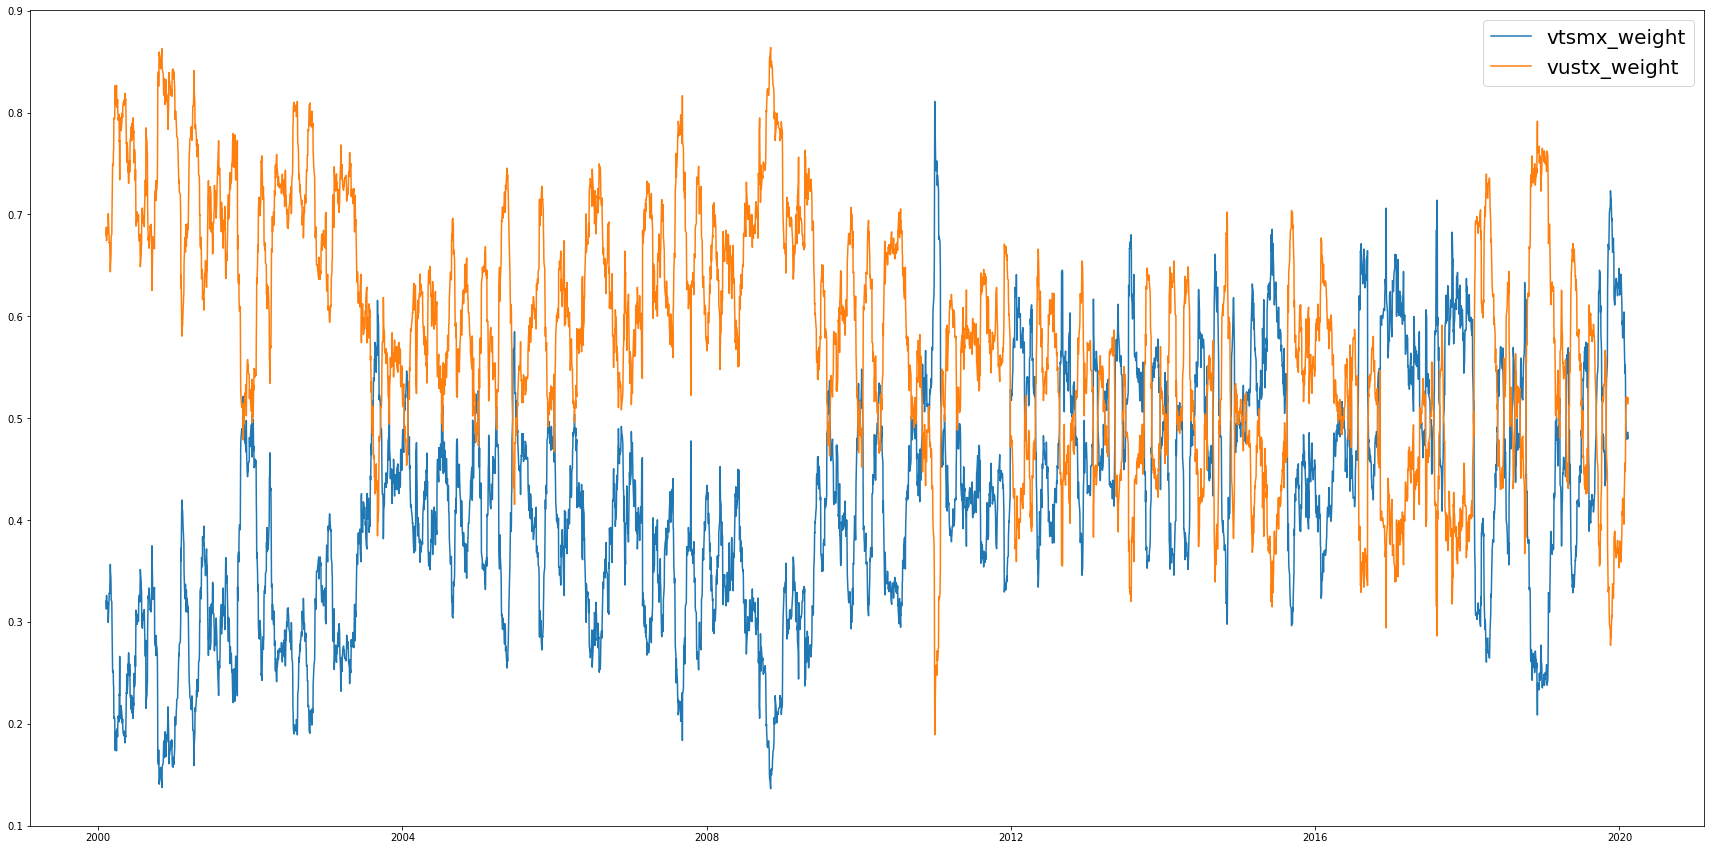

In [40]:
plt.rcParams['figure.figsize'] = [30, 15]

for x in allocation.columns.values:
    if x == "total_volatility" or x == "timestamp":
        continue
    plt.plot(allocation["timestamp"], allocation[x], label=x)

plt.legend(prop={'size': 20})

In [41]:
allocation

,timestamp,total_volatility,vtsmx_weight,vustx_weight
20,2000-02-08,247.116340,0.320361,0.679639
21,2000-02-09,249.244074,0.312523,0.687477
22,2000-02-10,239.954012,0.325903,0.674097
23,2000-02-11,245.944482,0.313435,0.686565
24,2000-02-14,247.383654,0.319236,0.680764
...,...,...,...,...
5049,2020-02-05,247.711963,0.485549,0.514451
5050,2020-02-06,251.672192,0.479540,0.520460
5051,2020-02-07,246.708473,0.485784,0.514216
5052,2020-02-10,247.552526,0.479779,0.520221
